In [3]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial
from scipy.optimize import minimize, differential_evolution, basinhopping
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from Nexis_model_forward import run_Nexis
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap


## Settings

In [19]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

# Specify individual seeding location (1) or cohort seed (0) (SET HERE)
individual_seed = 1

# Initial vector method ('baseline' or 'binary')
init_vec_method = 'baseline' 
if init_vec_method == 'binary':
    # Specify the binary region
    seeding_locations = ['ctx-lh-inferiortemporal', 'ctx-rh-inferiortemporal'] 

# Are you using multiple subtypes? (1) or not (0)
subtypes = 1
if subtypes == 1:
    # Specify number of subtypes (1 or 4)
    nsubtypes = 4

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) 
init_guess = np.array([0.2, 1.01, 1, 0.5, 0, 0, 50])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. 
bounds = [(0, 3),(0, 4),(1,1),(0.5,0.5),(0,0),(0,0),(50,50)]

## Load Data and Prepare Inputs

In [5]:
# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Define order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Conversion of ADNI region order to match connectivity matrix
ADNI_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)


In [6]:
# Load and prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [8]:
# Load and organize longitudinal data
longitudinal_stage_tau = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/Staging module output: stages and tau/longitudinal_stage_tau.csv')
columns_to_move = ['EXAMDATE', 'DX', 'time_elapsed', 'ml_stage']
other_columns = [col for col in longitudinal_stage_tau.columns if col not in columns_to_move]
new_column_order = columns_to_move + other_columns
longitudinal_stage_tau = longitudinal_stage_tau[new_column_order]
longitudinal_stage_tau = longitudinal_stage_tau.drop('Unnamed: 0', axis=1)
longitudinal_stage_tau = longitudinal_stage_tau.drop('ctx-rh-bankssts.1', axis=1)

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Conversion of ADNI region order to match connectivity matrix
ADNI_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

#  Delete striatal regions 
longitudinal_stage_tau = longitudinal_stage_tau.drop(regions_to_exclude, axis = 1)

# Reorder regions 
reordered_df = longitudinal_stage_tau.iloc[:, :5]  
region_columns = [col for col in regions if col in longitudinal_stage_tau.columns]
reordered_df = pandas.concat([reordered_df, longitudinal_stage_tau[region_columns]], axis=1)
longitudinal_stage_tau = reordered_df

# Keep onl dementia subjects with longitudinal data
dementia_rids = longitudinal_stage_tau[longitudinal_stage_tau['DX'] == 'Dementia']['RID'].unique()

# Filter out RIDs with NaN in ml_stage column 
longitudinal_stage_tau_dementia = longitudinal_stage_tau[
    #(longitudinal_stage_tau['RID'].isin(dementia_rids)) &
    (longitudinal_stage_tau['ml_stage'].notna())
]
# Calculate total tau
longitudinal_stage_tau_dementia['tau_sum'] = longitudinal_stage_tau_dementia.iloc[:, 5:].sum(axis=1)
columns = longitudinal_stage_tau_dementia.columns.tolist()
columns.insert(4, columns.pop(columns.index('tau_sum')))
longitudinal_stage_tau_dementia = longitudinal_stage_tau_dementia[columns]

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_58742/4087214108.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longitudinal_stage_tau_dementia['tau_sum'] = longitudinal_stage_tau_dementia.iloc[:, 5:].sum(axis=1)


In [21]:
# Load patient data from EBM

# Load EBM stage assignment data and empirical tau
patient_data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM stage + tau/Stage + tau - 2 subtypes.csv')
        
# Drop striatal regions first
patient_data = patient_data.drop(regions_to_exclude, axis=1)
        
# Get non-metadata columns (regions)
if subtypes == 0:
    metadata_cols = ['Unnamed: 0', 'RID', 'Diagnosis', 'ml_stage']
else:
    metadata_cols = ['Unnamed: 0', 'RID', 'Diagnosis', 'ml_stage', 'ml_subtype']
region_cols = [col for col in patient_data.columns if col not in metadata_cols]
        
# Create new column order: keep metadata columns, then reorder region columns to match 'regions' list
# Filter out excluded regions from the reference list
regions_filtered = [r for r in regions if r not in regions_to_exclude]
new_col_order = metadata_cols + regions_filtered
    
# Reorder columns
patient_data = patient_data[new_col_order]    

if individual == 0:
    # Upload EBM cohort level tau trejectories
    EBM_data = pandas.read_csv('EBM time series/EBM time series - version 9 final run.csv')
    # with tmax: EBM time series - version 9.csv (old final)
    # without tmax: EBM time series - version 9 final run.csv (FINAL)

    EBM_data = EBM_data.drop('Unnamed: 0', axis=1)

    # Normalize by mean at t=0
    t0_mean = EBM_data.iloc[0].mean()
    EBM_data = EBM_data / t0_mean 
    EBM_data = EBM_data / 10

    # Reorder regions to match region order of connectivity matrix
    EBM_data_reordered = EBM_data.iloc[:, ADNI_to_norm]

    # Delete striatal regions 
    columns_to_delete = EBM_data_reordered.columns[excluded_indices]
    EBM_data_excluded = EBM_data_reordered.drop(columns_to_delete, axis = 1)

    EBM_data_array = EBM_data_excluded.values
    EBM_data_transposed = EBM_data_array.T

else:
    #Select individual patient
    RID = 4197  #EDIT PATIENT RID MANUALLY HERE (2373 for figures 3, 4, 4197 for longitudinal validation) 
    patient = patient_data[patient_data['RID'] == RID]
    patient_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == RID]

    # Define number of time points 
    num_time_points = patient.shape[0]
    num_time_points_longitudinal = patient_longitudinal.shape[0]

    # Define list with stage assignments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    
    # Get tau data
    if subtypes == 0:
        patient_tau = patient.iloc[:, 4:].to_numpy().T
    else:
        patient_tau = patient.iloc[:, 5:].to_numpy().T

    # If subject had longitudinal data, repeat for longitudinal data
    if num_time_points_longitudinal > 1:
        # Delete baseline 
        patient_longitudinal = patient_longitudinal.iloc[1:]
        stages_longitudinal = patient_longitudinal['ml_stage'].tolist()
        stages_longitudinal = [int(x) for x in stages_longitudinal]
        patient_tau_longitudinal = patient_longitudinal.iloc[:,5:]
        patient_tau_longitudinal = patient_tau_longitudinal.to_numpy()
        patient_tau_longitudinal = patient_tau_longitudinal.T


Top seed regions: ['Left-VentralDC' 'ctx-rh-fusiform' 'Right-Amygdala'
 'ctx-rh-middletemporal' 'Left-Amygdala']
Threshold: 0.1406498944057976
Regions above threshold (regions that contribute to 90% of total seed energy): 13


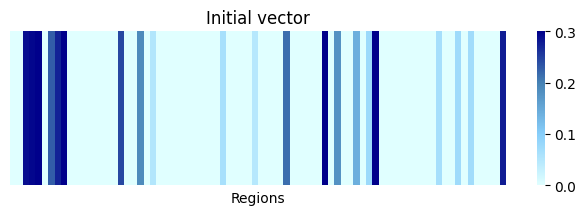

In [22]:
# Define seeding location/ Initial vector

if individual_seed == 1:

    individual_seeds = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/StaND results/final/Individual seeds.csv')
    init_vec = individual_seeds[individual_seeds['RID'] == RID].iloc[0].values[8:]
    init_vec = np.array(init_vec, dtype=np.float64)
    use_baseline_ = 1

else: 

    # OPTION 1: Use baseline data from EBM tau time series
    if init_vec_method == 'baseline':

        # Take the first row (time point 0) as initial vector
        # EBM BASELINE
        #init_vec = EBM_data_excluded.iloc[0].values 

        # seed op 1 
        #init_vec = np.array([0.0, 0.0, 0.1797912692781644, 0.3112351054181414, 0.0, 0.0, 0.017350048914301083, 0.11504920936757412, 0.30358564023811474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3855030378638843, 0.30657034607850436, 0.1613672211107048, 0.0, 0.0, 0.1305544150141248, 0.0, 0.021326554743881357, 0.4231532891750418, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17170024927971667, 0.0, 0.07424694031891696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02428139959456519, 0.41522338559802396, 0.302987767026093, 0.19187336331884614, 0.0, 0.0, 0.1304738518516531, 0.0, 0.03436054670019505, 0.28192517342399637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24776075268686057, 0.0, 0.09261264411068271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        # seed op 2
        init_vec = np.array([0.0, 0.0, 0.1514586323573524, 0.42836151855090715, 0.0, 0.0, 0.0017402925507693555, 0.0, 0.24759116345760815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12175048976781688, 0.15091551647443133, 0.29918278428170814, 0.0, 0.0, 0.12250147328025895, 0.0, 0.0, 0.3482878378043656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21530186438848417, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3627763979992332, 0.09081189212670127, 0.25426856912772555, 0.38861161764821844, 0.0, 0.011012838241325843, 0.12067612758145085, 0.0, 0.0, 0.21179516355228645, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01639841292541576, 0.0, 0.024597765319579586, 0.08323582650742528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        use_baseline_ = 1

    #OPTION 2: Binary vector indicating seeding location 
    if init_vec_method == 'binary':

        seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

        # Create a 1D array of zeros with length nROI
        array_length = nROI
        init_vec = np.zeros(array_length)

        # Set entries for seeding locations to 1 (both left and right hemisphere)
        init_vec[seeding_indices[0]] = 1 
        init_vec[seeding_indices[1]] = 1

        # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
        use_baseline_ = 0 


# FIX THIS SOMETHING WRONG HERE! (selecting the wrong top regions and not displaying them correctly)
# Print highest tau seed regions
top_seed_values = sorted(init_vec, reverse=True)[:5]
top_indices = sorted(range(len(init_vec)), key=lambda i: init_vec[i], reverse=True)[:5]
regions_array = np.array(regions)
top_seeds = regions_array[top_indices]
print('Top seed regions: ' + str(top_seeds))

blue_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#E0FFFF", "#87CEFA", "#4682B4", "#00008B"])

# Plot initial vector as heatmap
plt.figure(figsize=(8, 2)) 
init_vec_reshaped = init_vec.reshape((78,1))
sns.heatmap(init_vec_reshaped.T, cmap=blue_cmap, xticklabels=False, yticklabels=False, vmax = 0.3)
plt.xlabel('Regions')
plt.title('Initial vector')

# Calculate intial vector sparsity

def energy_calc(seed): 
    seed = np.array(seed)
    seed_ordered = np.sort(seed)[::-1]
    seed_sum = seed.sum()
    percent_of_sum = seed_sum * 0.9

    temp_sum = 0
    for value in seed_ordered:
        temp_sum = temp_sum + value
        if temp_sum > percent_of_sum:
            threshold = value
            print('Threshold: ' + str(threshold))
            count_sparse_regions = np.sum(seed > threshold)
            print('Regions above threshold (regions that contribute to 90% of total seed energy): ' + str(count_sparse_regions))
            return
        
energy_calc(init_vec)

In [375]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
DK_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[DK_to_norm, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

##  Define inputs to NEXIS

In [376]:
C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1))  # Don't care about cell types (nROI x nTypes), set to nROI x 1 array of random numbers or 0
init_vec_ = init_vec # Initial tau vector (nROI x 1)

if individual == 1:
    t_vec_ = np.linspace(0, 18, 19)
else:
    t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without

## Parameter Optimization

In [377]:
# Define cost function 
def Nexis_error(params, patient_tau):
    
    param1, param2, param3, param4, param5, param6, param7 = params 
    # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 =k
    
   # Initialize run_Nexis object 
    nexis_optimizing = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_ = logistic_term_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_optimizing.simulate_nexis(parameters)

    if individual == 1:
        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 

        # Check if Y_edited is constant
        if np.all(Y_edited == Y_edited[0]):
            Y_edited[0] = Y_edited[0] + 0.00001 # Add small constant 
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1- corr_coeff) 
    
    else:
        # Fit to EBM interpolation
        corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
        error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff)
    
    return error



In [378]:
# Run optimization

# Save error values to plot
error_values = []
def callback(params):
    error = Nexis_error(params, patient_tau)
    error_values.append(error)

custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

# Perform the optimization
result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='Powell', options={'xtol': 1e-4, 'ftol': 1e-4,'maxiter': 1000}) # Methods: Powell OR L-BFGS-B
#result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='L-BFGS-B',options={'disp': True, 'maxiter': 1000}, callback=callback)

if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist()
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
    print(f"Final error (value of objective function): {result.fun}")
else:
    print("Optimization failed.", result.message)
    print(f"Final error (value of objective function): {result.fun}")

# Plot error values across iterations
# plt.figure(figsize=(10, 8))
# plt.plot(range(len(error_values)), error_values, marker='o', linestyle='-', linewidth= 3, color='#6B8E23')
# plt.xlabel('Iteration')
# plt.ylabel('Error')
# plt.title('Error Value Across Iterations')
# plt.show()

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.22052231725265928, 0.18088495467607466, 1.0, 0.5, 0.0, 0.0, 50.0]
Final error (value of objective function): 0.05791928304618577


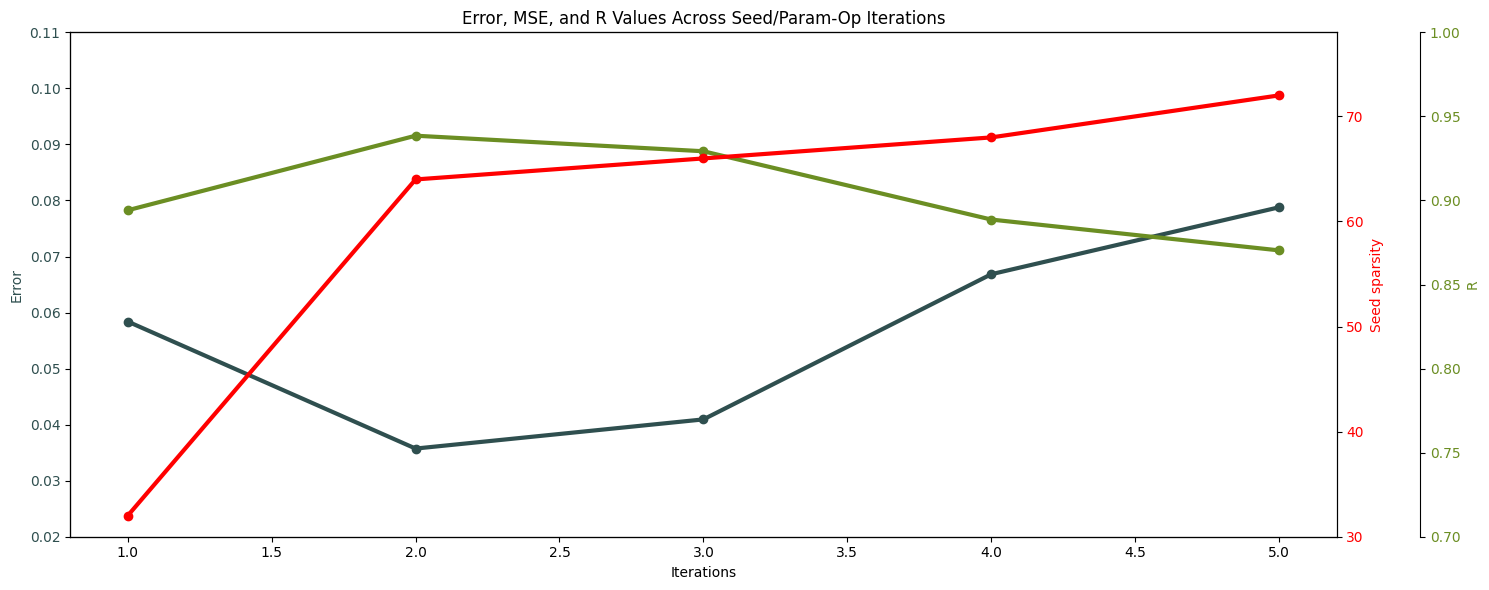

In [292]:
# Plot objective function error across iterations
R_iter = [0.894166, 0.93852, 0.929269, 0.8886485722306087,0.8703098915770444]
MSE_iter = [0.0055, 0.004997, 0.00556923, 0.011161025148224125, 0.013938324288192585]
error_iter = np.array([0.058397, 0.03573, 0.0409345091, 0.06683673903291978, 0.07878337849967038])
seed_sparsity = np.array([32,64,66,68,72])
iterations = np.array([1, 2, 3, 4, 5])

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Error
line1 = ax1.plot(iterations, error_iter, marker='o', linestyle='-', linewidth=3, color='#2F4F4F', label='Error')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Error', color='#2F4F4F')
ax1.tick_params(axis='y', labelcolor='#2F4F4F')
err_min, err_max = 0.02, 0.11
ax1.set_ylim(err_min, err_max)

# Plot MSE
# ax2 = ax1.twinx()
# line2 = ax2.plot(iterations, MSE_iter, marker='o', linestyle='-', linewidth=3, color='#A8D5BA', label='MSE')
# ax2.set_ylabel('MSE', color='#A8D5BA')
# ax2.tick_params(axis='y', labelcolor='#A8D5BA')
# mse_min, mse_max = 0.003, 0.016
# ax2.set_ylim(mse_min, mse_max)

# Plot R
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outward
line3 = ax3.plot(iterations, R_iter, marker='o', linestyle='-', linewidth=3, color='#6B8E23', label='R')
ax3.set_ylabel('R', color='#6B8E23')
ax3.tick_params(axis='y', labelcolor='#6B8E23')
r_min, r_max = 0.7, 1
ax3.set_ylim(r_min, r_max)

# Plot sparsity
ax4 = ax1.twinx()
line4 = ax4.plot(iterations, seed_sparsity, marker='o', linestyle='-', linewidth=3, color='red', label='Seed sparsity')
ax4.set_xlabel('Iterations')
ax4.set_ylabel('Seed sparsity', color='red')
ax4.tick_params(axis='y', labelcolor='red')
spa_min, spa_max = 30, 78
ax4.set_ylim(spa_min, spa_max)

# Add a title
plt.title('Error, MSE, and R Values Across Seed/Param-Op Iterations')

# Add legend
# lines = line1 + line3 + line4
# labels = [l.get_label() for l in lines]
# ax1.legend(lines, labels, loc='upper right')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [33]:
# TESTING: Looping through different initial guesses and trying different optimization algorthyms (DELETE LATER)

from scipy.optimize import minimize, differential_evolution, basinhopping

def safe_objective(params):
    try:
        print("Input parameters:", params)
        result = custom_Nexis_error(params)  
        if np.isinf(result) or np.isnan(result):
            print("Warning: Infinite or NaN result")
            return 1e10  # A large, finite number
        return result
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1e10  # A large, finite number

# Check input data
print("Any NaN in patient_tau:", np.isnan(patient_tau).any())
print("Any inf in patient_tau:", np.isinf(patient_tau).any())

# Parameter bounds
bounds = [(0, 2), (0, 3), (1, 1), (0.5, 0.5), (0, 0), (0, 0), (50, 50)]

# Multiple starting points
initial_guesses = [
    [0.1, 0.1, 1.0, 0.5, 0, 0.0, 50],
    [0.5, 0.5, 1.0, 0.5, 0, 0.0, 50],
    [1, 1, 1.0, 0.5, 0, 0.0, 50]
]
# Global optimization using Differential Evolution
de_result = differential_evolution(safe_objective, bounds, strategy='best1bin', 
                                   popsize=15, tol=0.01, mutation=(0.5, 1), 
                                   recombination=0.7, seed=None, maxiter=1000, 
                                   polish=True)

# Global optimization using Basin-hopping
bh_result = basinhopping(safe_objective, initial_guesses[0], niter=100, T=1.0, 
                         stepsize=0.5, minimizer_kwargs={'method': 'L-BFGS-B', 'bounds': bounds})

# Compare results
results = [de_result, bh_result]
best_overall = min(results, key=lambda x: x.fun)

print(f"Best parameters: {best_overall.x}")
print(f"Best objective value: {best_overall.fun}")


Any NaN in patient_tau: False
Any inf in patient_tau: False
Input parameters: [2.24815178e-02 2.91730879e+00 1.00000000e+00 5.00000000e-01
 0.00000000e+00 0.00000000e+00 5.00000000e+01]
Result: 0.46057185736572254
Input parameters: [ 1.85336917  0.12467519  1.          0.5         0.          0.
 50.        ]
Result: 2478.657207290319
Input parameters: [ 0.98326135  0.95234063  1.          0.5         0.          0.
 50.        ]
Result: 1915.3913039391134
Input parameters: [ 1.67370738  2.76539845  1.          0.5         0.          0.
 50.        ]
Result: 2479.0188902994546
Input parameters: [ 0.54165037  1.89048785  1.          0.5         0.          0.
 50.        ]
Result: 37.23928234229349
Input parameters: [ 1.13763323  2.16060757  1.          0.5         0.          0.
 50.        ]
Result: 2313.4727760730707
Input parameters: [ 0.22903813  1.79608669  1.          0.5         0.          0.
 50.        ]
Result: 0.48976424593382556
Input parameters: [ 1.60183157  2.59176604 

## Running Nexis

Pearsons R: 0.8988350990472674
Mean squared error: 0.0073368325698194925
Final error: 0.05791928304618577


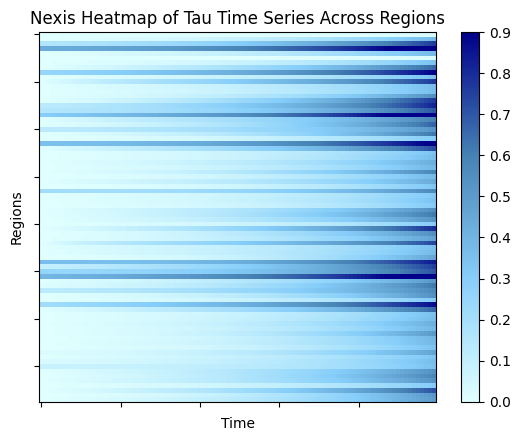

In [379]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_)

# Parameters for simulate_nexis method
parameters = optimized_params  # [alpha, beta, gamma, s, b, p, k] 

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual == 1:
    Y_edited = Y[:, stages] # Take stages from Y that correspond to patient's stages 
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
    mse = mse_matrix(patient_tau, Y_edited)
    final_error = mse + 0.5 * (1- corr_coeff)
else:
    normalized_Y = normalize_by_l2_norm(Y) # Normalize by L2 norm
    corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
    mse = mse_matrix(EBM_data_transposed, Y)
    final_error = mse + 0.5 * (1- corr_coeff)
    
print('Pearsons R: ' + str(corr_coeff))
print('Mean squared error: ' + str(mse))
print('Final error: ' + str(final_error))

# Plot heatmap of Y
plt.imshow(Y, cmap=blue_cmap, interpolation='none', aspect='auto', vmax = 0.9)
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Nexis Heatmap of Tau Time Series Across Regions')
plt.xlabel('Time')  
plt.ylabel('Regions')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])

for spine in ax.spines.values():
    spine.set_visible(True)


In [334]:
# Save NDM to csv to visualize with PySurfer (initial and final cohort-level iterations)
Y_df = pandas.DataFrame(Y.T, columns=regions)
Y_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/visualization/Pysurfer data/2373_individualparam_model.csv')

## Check Results

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/1116256345.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5, linestyle = '--')


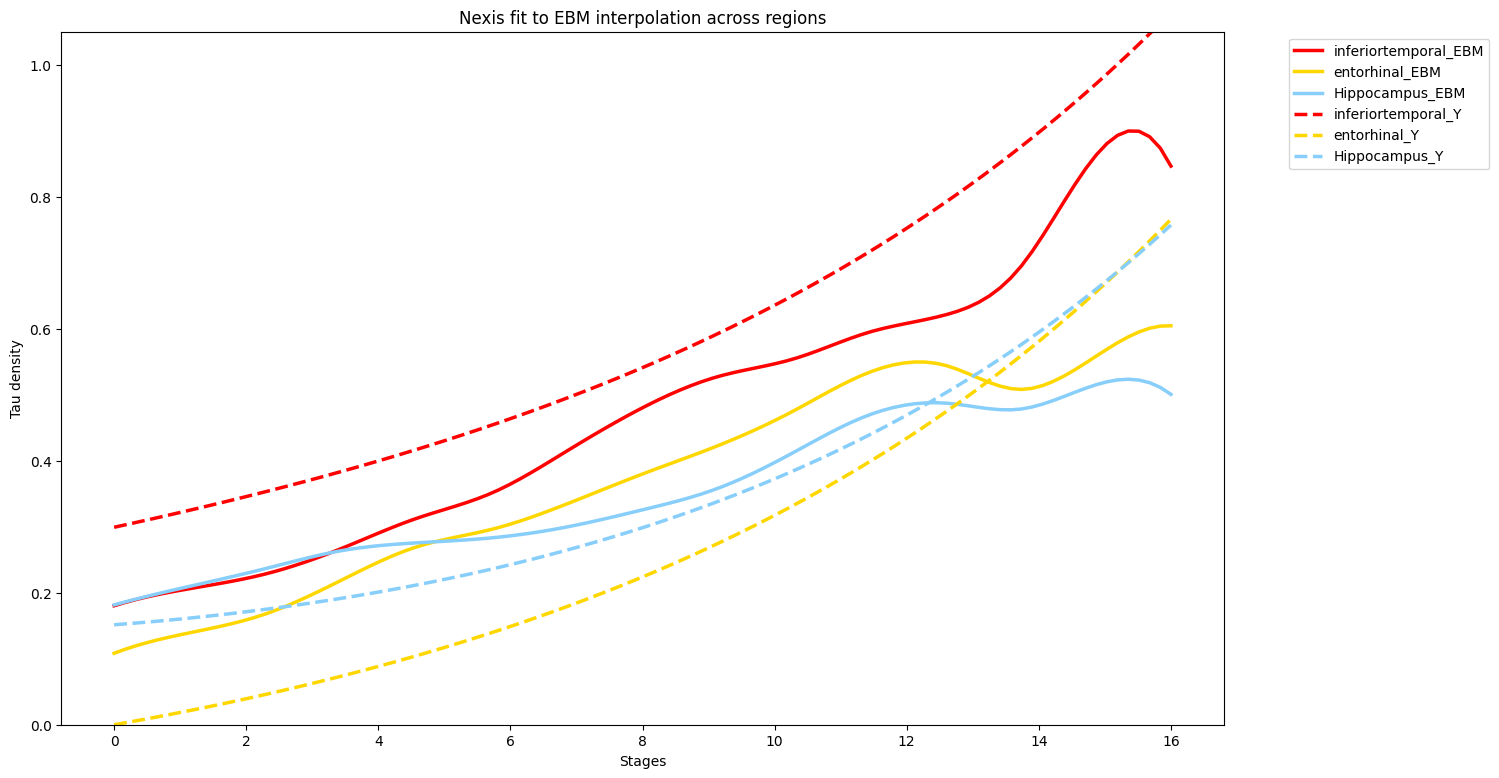

In [380]:
# Plot regions of Y against those region in EBM regional interpolations

if individual == 0:

    Y_for_figure = pandas.DataFrame(Y)
    Y_for_figure = Y_for_figure.T
    Y_for_figure.columns = regions
    Y_for_figure = Y_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
    Y_for_figure = Y_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_Y', 'ctx-lh-entorhinal': 'entorhinal_Y', 'Left-Hippocampus': 'Hippocampus_Y'})

    EBM_for_figure = pandas.DataFrame(EBM_data_transposed)
    EBM_for_figure = EBM_for_figure.T
    EBM_for_figure.columns = regions
    EBM_for_figure = EBM_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
    EBM_for_figure = EBM_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_EBM', 'ctx-lh-entorhinal': 'entorhinal_EBM', 'Left-Hippocampus': 'Hippocampus_EBM'})

    for_figure = pandas.merge(EBM_for_figure,Y_for_figure,left_index=True, right_index=True)

    plt.figure(figsize=(15, 9))
    plt.ylim(0, 1.05)
    colors = ['#FE0101', '#FFD700', '#87CEFA'] #'#FE0101', '#FFD700', '#00008B', '#FA8072', '#FFFF66', '#87CEFA'
    xnew = np.linspace(0, 16, 100) 

    for idx, (col, color) in enumerate(zip(for_figure.columns[0:3], colors)):
        col_data = for_figure[col]
        plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5)

    for idx, (col, color) in enumerate(zip(for_figure.columns[3:6], colors)):
        col_data = for_figure[col]
        plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5, linestyle = '--')

    # Remove tick labels but keep ticks
    #plt.gca().set_xticklabels([])
    #plt.gca().set_yticklabels([])

    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)

    # Keep axis labels
    plt.title('Nexis fit to EBM interpolation across regions')
    plt.xlabel('Stages')
    plt.ylabel('Tau density')

    # Show the plot
    plt.show()


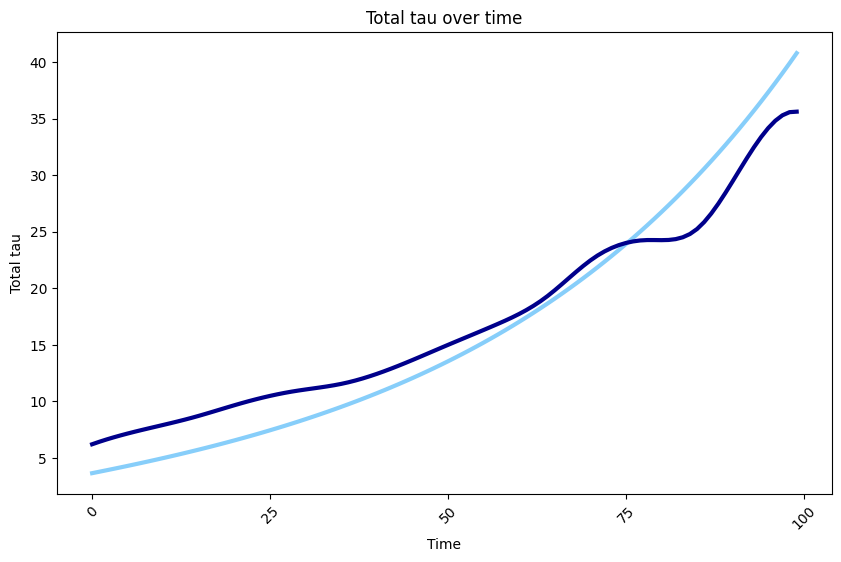

In [381]:
# regional_volumes_array = np.array(regional_volumes_excluded)
# regional_volumes_array = regional_volumes_array.reshape((78,1))
# tau_mass_Y = regional_volumes_array * Y
# total_tau_Y = np.sum(tau_mass_Y, axis=0)
total_tau_Y = np.sum(Y, axis=0)

if individual == 1:
    # Volume correction
    patient_tau = patient_tau.reshape(78,1)
    #tau_mass_patient = regional_volumes_array * patient_tau
    #total_tau_patient = np.sum(tau_mass_patient, axis=0)
    total_tau_patient = np.sum(patient_tau, axis=0)

    time_points_Y = np.linspace(0, 18, 19)
    plt.figure(figsize=(10, 8))
    plt.xlim(0,18)

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, linestyle='-', linewidth = 3, color='#87CEFA', label= 'Y')  

    # Plot total_tau_patient on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='#00008B', label= 'patient', markersize=18, markeredgewidth=4)

    plt.title('Total tau over time') 
    plt.xlabel('Stage')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    #plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show
    
else:
    # Plot total tau over time to compare the scales of EBM and Y
    # EBM_mass = regional_volumes_array * EBM_data_excluded
    # EBM_total_tau = np.sum(EBM_mass, axis=1)
    EBM_total_tau = np.sum(EBM_data_excluded, axis=1)

    time_points = np.linspace(0, 99, 100)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    #plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  
    plt.plot(time_points, total_tau_Y, linestyle='-', color='#87CEFA', linewidth=3, label= 'Y')  

    # Plot EBM interpolation on the same graph
    plt.plot(time_points, EBM_total_tau, linestyle='-', color='#00008B', linewidth=3, label= 'EBM')

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.xticks([0, 25, 50, 75, 100])
    #plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/418758739.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlations_df = pandas.concat([correlations_df, new_row], ignore_index=True)
/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/418758739.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stage Range', bbox_to_anchor=(1.05, 1), loc='upper left')



Mean correlation coefficient (R): 0.514


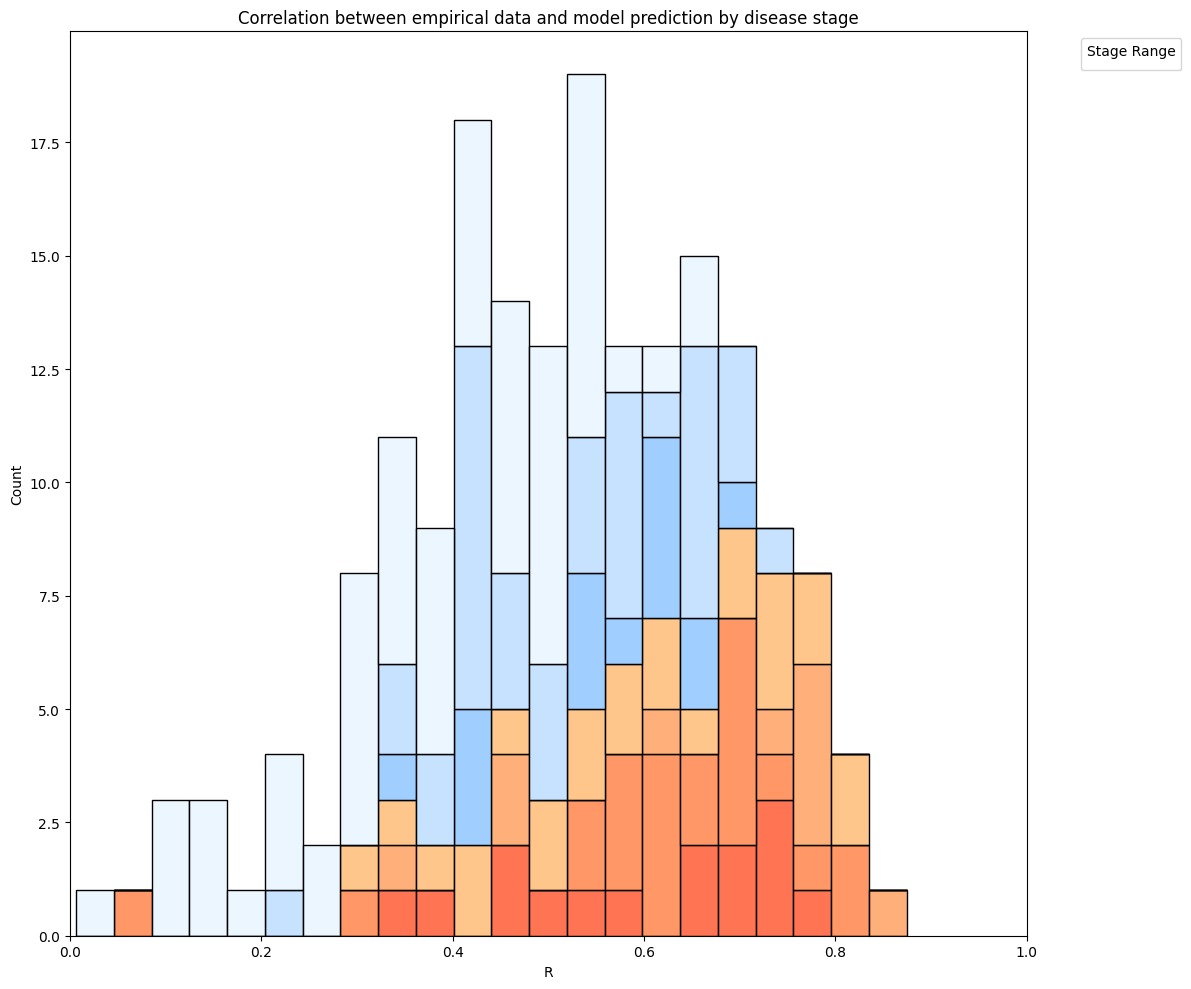


Mean R values by diagnosis:
Diagnosis
Dementia    0.568001
MCI         0.486716
Name: R, dtype: float64


/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/418758739.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([''])


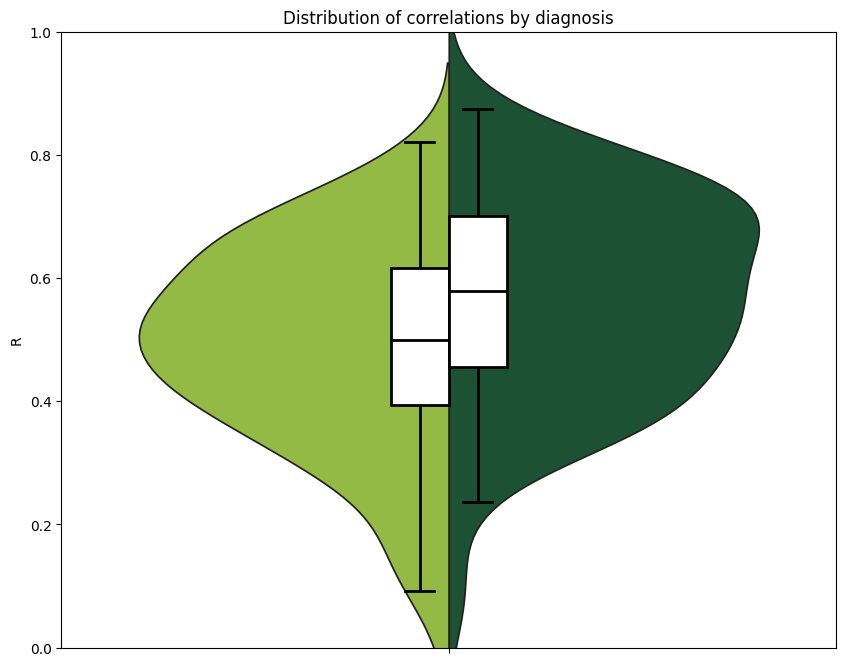


Detailed Statistics:

MCI:
Mean R: 0.487
Median R: 0.498
Std R: 0.169
Min R: 0.006
Max R: 0.820
N: 121

Dementia:
Mean R: 0.568
Median R: 0.579
Std R: 0.165
Min R: 0.085
Max R: 0.875
N: 62


In [384]:
# Plot correlation between Y (optimized to EBM trajectory) and empirical tau at their EBM assigned stage

color_palette = {
    'Dementia': '#145A32',  # Deep evergreen
    'MCI': '#9ACD32',       # Yellow-green
    'CN': '#FFFACD'}        # Light yellow/cream

# Plot correlation between Y (optimized to EBM trajectory) and empirical tau at their EBM assigned stage
if individual == 0:
    # Create DataFrame to store results
    column_names = ['RID', 'Diagnosis', 'ml_stage', 'R', 'p_value']
    correlations_df = pandas.DataFrame(columns=column_names)

    # Get unique RIDs for MCI and Dementia subjects only, excluding stage 0
    unique_rids = patient_data[
        (patient_data['Diagnosis'].isin(['MCI', 'Dementia'])) & 
        (patient_data['ml_stage'] > 0)
    ]['RID'].unique()

    # For each subject
    for rid in unique_rids:
        # Get subject data
        patient = patient_data[patient_data['RID'] == rid]
        
        # Get stage and diagnosis
        ml_stage = patient['ml_stage'].iloc[0]
        diagnosis = patient['Diagnosis'].iloc[0]
        
        # Convert ml_stage to corresponding Y timepoint
        # Map stage (0-16) to timepoint (0-99)
        y_timepoint = int(round((ml_stage / 16) * 99))  # Using 99 since Y has 100 columns indexed 0-99
        
        # Get Y vector at mapped timepoint
        y_vector = Y[:, y_timepoint]
        
        # Get empirical tau vector (excluding metadata columns)
        if subtypes == 0:
            empirical_tau = patient.iloc[0, 4:].values
        else:
            empirical_tau = patient.iloc[0, 5:].values
        
        # Calculate correlation
        r_value, p_value = pearsonr(y_vector, empirical_tau)
        
        # Add to DataFrame
        new_row = pandas.DataFrame({
            'RID': [rid],
            'Diagnosis': [diagnosis],
            'ml_stage': [ml_stage],
            'R': [r_value],
            'p_value': [p_value]
        })
        correlations_df = pandas.concat([correlations_df, new_row], ignore_index=True)


    # Calculate and print mean R value
    mean_R = correlations_df['R'].mean()
    print(f"\nMean correlation coefficient (R): {mean_R:.3f}")

    # Create histogram organized by stage
    plt.figure(figsize=(12, 10))
    correlations_df['stage_bin'] = pandas.cut(correlations_df['ml_stage'], 
                                            bins=[0, 2, 4, 6, 8, 10, 12, 14, 16],
                                            labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16'])
    stage_palette = sns.color_palette([
        "#E6F3FF",  # Lightest blue
        "#B3D9FF",  # Light blue
        "#80BFFF",  # Medium blue
        "#FFB366",  # Light orange
        "#FF944D",  # Medium orange
        "#FF7533",  # Dark orange
        "#FF471A",  # Light red
        "#CC0000",  # Deep red
    ])
    ax = sns.histplot(data=correlations_df, x='R', binwidth=0.04, 
                    hue='stage_bin', multiple='stack', 
                    palette=stage_palette, legend=True)

    plt.xlabel('R')
    plt.ylabel('Count')
    plt.title('Correlation between empirical data and model prediction by disease stage')
    plt.xlim(0, 1)
    plt.legend(title='Stage Range', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Print mean R by diagnosis
    print("\nMean R values by diagnosis:")
    print(correlations_df.groupby('Diagnosis')['R'].mean())

    # Create violin plot
    # For diagnoses 
    
    plt.figure(figsize=(10, 8))
    violin_data = correlations_df[correlations_df['Diagnosis'].isin(['MCI', 'Dementia'])]
    sns.violinplot(data=violin_data, 
                x=['dummy']*len(violin_data), 
                y='R',
                hue='Diagnosis', 
                split=True,
                palette=color_palette, 
                legend=False,
                inner=None) 
    sns.boxplot(data=violin_data,
                x=['dummy']*len(violin_data),
                y='R',
                hue='Diagnosis',
                width=0.15,         
                showfliers=False,   
                linewidth=2,
                legend=False,
                boxprops={'facecolor': 'white', 'edgecolor': 'black'},
                whiskerprops={'color': 'black'},
                capprops={'color': 'black'},
                medianprops={'color': 'black'})            

    plt.ylim(0, 1)  # Set y-axis limits
    plt.title('Distribution of correlations by diagnosis')
    plt.xlabel('')  # Remove x-label since we're using a dummy variable
    plt.ylabel('R')
    plt.gca().set_xticklabels([''])
    plt.show()

    # Print additional statistics
    print("\nDetailed Statistics:")
    for diagnosis in correlations_df['Diagnosis'].unique():
        subset = correlations_df[correlations_df['Diagnosis'] == diagnosis]
        print(f"\n{diagnosis}:")
        print(f"Mean R: {subset['R'].mean():.3f}")
        print(f"Median R: {subset['R'].median():.3f}")
        print(f"Std R: {subset['R'].std():.3f}")
        print(f"Min R: {subset['R'].min():.3f}")
        print(f"Max R: {subset['R'].max():.3f}")
        print(f"N: {len(subset)}")

## Loop Through All Subjects 
If running on individuals

In [359]:
# Loop through all subjects (DIFFERENTIAL EVOLUTION)

# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

# Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'MSE_longitudinal', 'R_longitudinal', 'alpha', 'beta', 'gamma', 's', 'b', 'p', 'k']
parameters_all = pandas.DataFrame(columns=column_names)

# Define bounds for differential evolution
bounds = [(0, 2),    # alpha
         (0, 3),     # beta
         (1, 1),     # gamma
         (0.5, 0.5), # s
         (0, 0),     # b
         (0, 0),     # p
         (50, 50)]   # k


# Create dictionary for entire time series for each subject
timeseries_all_dict = {}

for rid in unique_rids:
    patient = patient_data[patient_data['RID'] == rid] 
    patient_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]

    # Define number of time points 
    num_time_points = patient.shape[0]
    num_time_points_longitudinal = patient_longitudinal.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    if subtypes == 0:
        patient_tau = patient.iloc[:,4:].to_numpy().T
    else:
        patient_tau = patient.iloc[:,5:].to_numpy().T

    # If subject had longitudinal data, repeat for longitudinal data
    if num_time_points_longitudinal > 1:
        patient_longitudinal = patient_longitudinal.iloc[1:]
        stages_longitudinal = patient_longitudinal['ml_stage'].tolist()
        stages_longitudinal = [int(x) for x in stages_longitudinal]
        patient_tau_longitudinal = patient_longitudinal.iloc[:,5:].to_numpy().T

    if individual_seed == 1:
        init_vec = individual_seeds[individual_seeds['RID'] == rid].iloc[0].values[8:]
        init_vec = np.array(init_vec, dtype=np.float64)
        nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec, t_vec_=t_vec_, w_dir_=w_dir_,
                            volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                            region_volumes_=region_volumes_, logistic_term_=logistic_term_)

    # Check for NaN or inf values
    if np.isnan(patient_tau).any() or np.isinf(patient_tau).any():
        print(f"Skipping RID {rid} due to NaN or inf values in patient_tau")
        continue

    # Define objective function with error handling
    def safe_objective(params):
        try:
            Y = nexis_model.simulate_nexis(params)
            Y_edited = Y[:, stages]
            if np.isnan(Y_edited).any() or np.isinf(Y_edited).any():
                return 1e10
            mse = mse_matrix(patient_tau, Y_edited)
            corr_coeff, _ = pearsonr(patient_tau.flatten(), Y_edited.flatten())
            return mse + 0.5 * (1 - corr_coeff)
        except Exception as e:
            print(f"Error for RID {rid}: {e}")
            return 1e10

    # Perform differential evolution
    result = differential_evolution(
        safe_objective, 
        bounds,
        strategy='best1bin',
        maxiter=1000,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        polish=True
    )
    
    if result.success:
        optimized_params = result.x.tolist()

        # Run Nexis with optimized parameters
        Y = nexis_model.simulate_nexis(optimized_params)
        Y_edited = Y[:, stages]
        
        # Calculate final MSE and R
        mse = mse_matrix(patient_tau, Y_edited)
        corr_coeff, _ = pearsonr(patient_tau.flatten(), Y_edited.flatten())

        if num_time_points_longitudinal > 1:
            Y_edited_longitudinal = Y[:, stages_longitudinal]
            mse_longitudinal = mse_matrix(patient_tau_longitudinal, Y_edited_longitudinal)
            corr_coeff_longitudinal, p_value_longitudinal = pearsonr(patient_tau_longitudinal.flatten(), Y_edited_longitudinal.flatten())
        
        # Create data frame for the subject

        if num_time_points_longitudinal > 1:
            parameters = pandas.DataFrame(
                [[rid] + [mse] + [corr_coeff] + [mse_longitudinal] + [corr_coeff_longitudinal] + optimized_params], 
                columns=column_names)
        else:
            parameters = pandas.DataFrame(
                [[rid] + [mse] + [corr_coeff] + ['NaN'] + ['NaN'] + optimized_params], 
                columns=column_names)
        parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)
    
        # Create df for timeseries and add to dictionary
        timeseries = pandas.DataFrame(Y)
        timeseries_all_dict[rid] = timeseries

    else:
        print(f"Optimization failed for RID {rid}")

# Add diagnosis and ml_stage information
parameters_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
parameters_all.insert(2, 'ml_stage', patient_data['ml_stage'])
if subtypes == 1:
    parameters_all.insert(3, 'ml_subtype', patient_data['ml_subtype'])

# Print summary statistics
print("\nOptimization Results Summary:")
print(f"Mean R: {parameters_all['R'].mean():.3f} ± {parameters_all['R'].std():.3f}")
print(f"Mean MSE: {parameters_all['MSE'].mean():.3f} ± {parameters_all['MSE'].std():.3f}")
print(f"Successful optimizations: {len(parameters_all)} out of {len(unique_rids)}")

parameters_all

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/2243048059.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)



Optimization Results Summary:
Mean R: 0.298 ± 0.183
Mean MSE: 0.033 ± 0.047
Successful optimizations: 650 out of 650


,RID,Diagnosis,ml_stage,ml_subtype,MSE,R,MSE_longitudinal,R_longitudinal,alpha,beta,gamma,s,b,p,k
0,21,CN,1.0,1.0,0.012810,0.342892,NaN,NaN,0.952534,2.181380,1.0,0.5,0.0,0.0,50.0
1,31,CN,0.0,0.0,0.030893,0.084075,0.063813,0.390135,1.796934,1.967947,1.0,0.5,0.0,0.0,50.0
2,56,MCI,1.0,1.0,0.007382,0.373187,0.009945,0.380906,1.240904,3.000000,1.0,0.5,0.0,0.0,50.0
3,59,MCI,1.0,1.0,0.010272,0.424562,NaN,NaN,1.281743,3.000000,1.0,0.5,0.0,0.0,50.0
4,69,MCI,2.0,1.0,0.007346,0.595423,0.035168,0.560427,0.666870,1.335679,1.0,0.5,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,6704,MCI,3.0,0.0,0.003591,0.424292,NaN,NaN,0.265395,0.833907,1.0,0.5,0.0,0.0,50.0
646,6705,MCI,6.0,1.0,0.008991,0.308489,NaN,NaN,0.000000,0.294928,1.0,0.5,0.0,0.0,50.0
647,6713,CN,0.0,0.0,0.040154,0.198057,NaN,NaN,1.475315,1.051286,1.0,0.5,0.0,0.0,50.0
648,6721,Dementia,4.0,0.0,0.013479,0.311285,NaN,NaN,0.282741,0.567247,1.0,0.5,0.0,0.0,50.0


In [361]:
# Save dictionary with timeseries for each subject
import pickle
with open('StaND results/final/timeseries_all_dict_subtypes_2_inferiortemporal.pkl', 'wb') as f:
    pickle.dump(timeseries_all_dict, f)

In [362]:
# Save to a csv 
parameters_all.to_csv('StaND results/binary benchmark seeds/Optimized param - subtypes_2_inferiortemporal.csv')

In [395]:
parameters_all = pandas.read_csv('StaND results/binary benchmark seeds/Optimized param - subtypes_2_fusiform.csv')


Mean correlation coefficient (R) by subtype:
ml_subtype
0.0    0.411212
1.0    0.487908
Name: R, dtype: float64


/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/3992214347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_parameters['stage_bin'] = pandas.cut(filtered_parameters['ml_stage'],
/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_953/3992214347.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stage Range', bbox_to_anchor=(1.05, 1), loc='upper left')


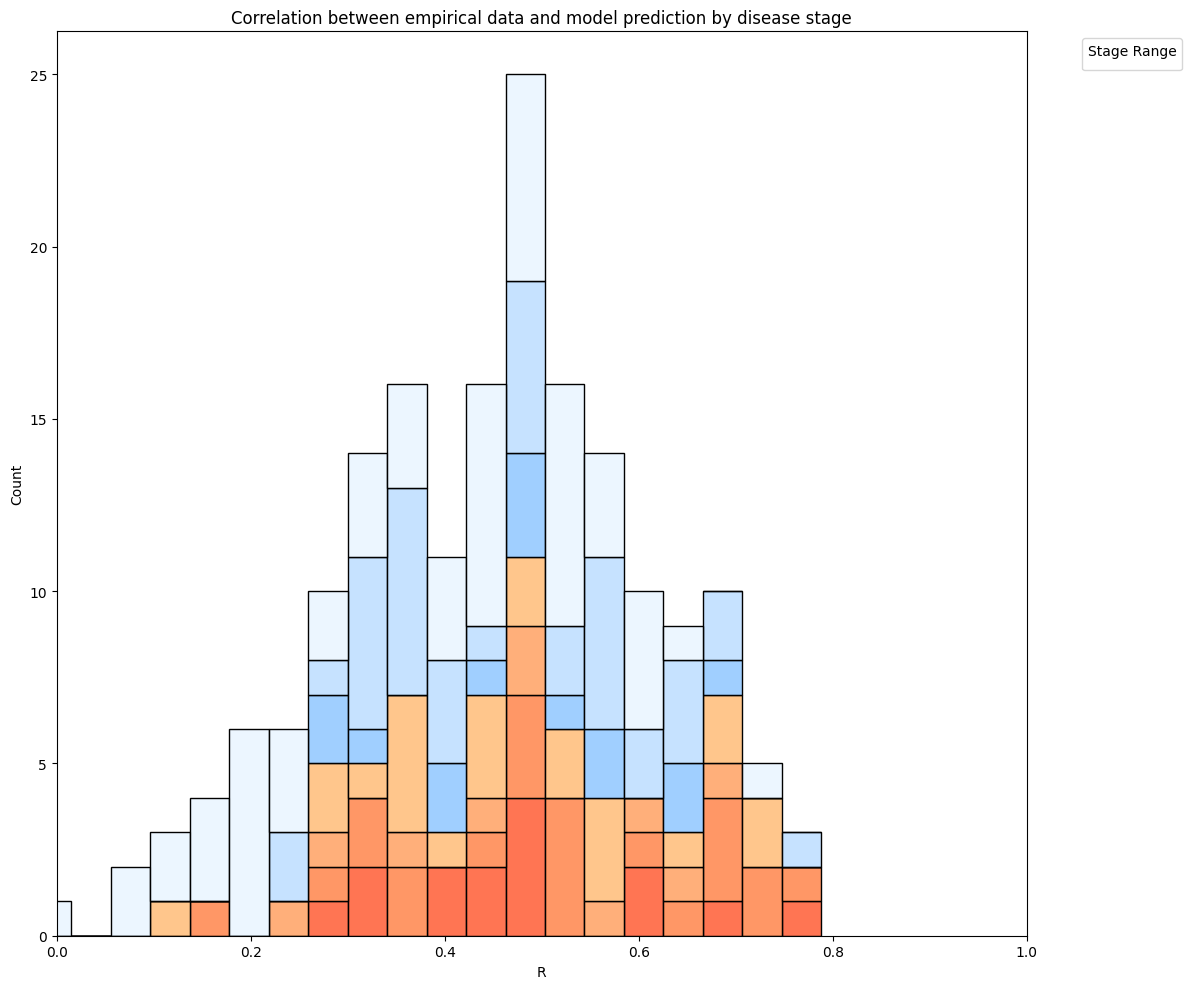

Mean correlation coefficient (R) across all subjects: 0.444


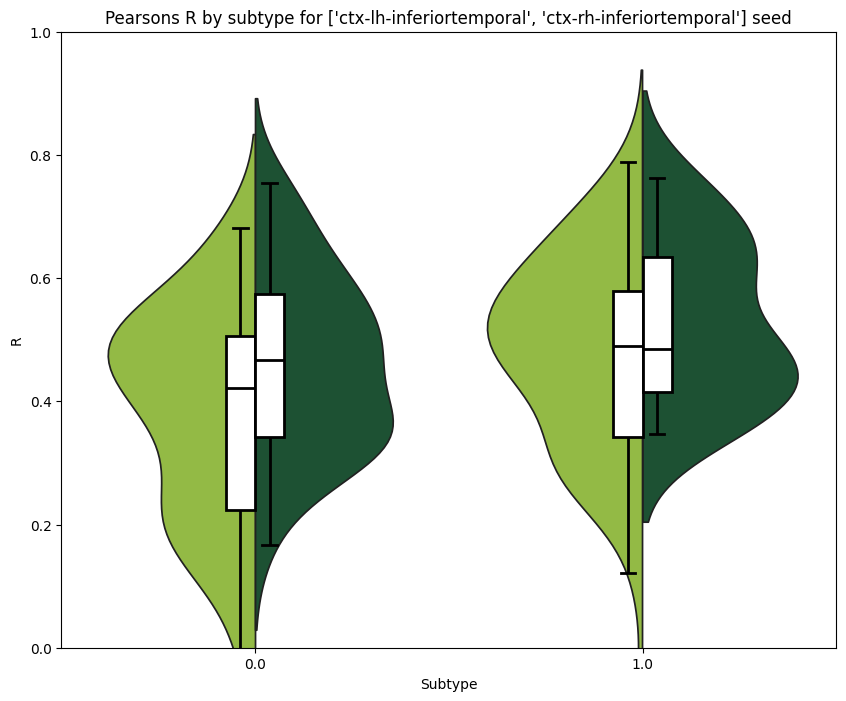

In [396]:
# Filter out stage 0 and control subjects
filtered_parameters = parameters_all[
    (parameters_all['ml_stage'] != 0) & 
    (parameters_all['Diagnosis'] != 'CN')
]

# Calculate and print mean R by subtype
mean_R_by_subtype = filtered_parameters.groupby('ml_subtype')['R'].mean()
print("\nMean correlation coefficient (R) by subtype:")
print(mean_R_by_subtype)


plt.figure(figsize=(12, 10))
filtered_parameters['stage_bin'] = pandas.cut(filtered_parameters['ml_stage'], 
                                            bins=[0, 2, 4, 6, 8, 10, 12, 14, 16],
                                            labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16'])
stage_palette = sns.color_palette([
        "#E6F3FF",  # Lightest blue
        "#B3D9FF",  # Light blue
        "#80BFFF",  # Medium blue
        "#FFB366",  # Light orange
        "#FF944D",  # Medium orange
        "#FF7533",  # Dark orange
        "#FF471A",  # Light red
        "#CC0000",  # Deep red
    ])
    
ax = sns.histplot(data=filtered_parameters, x='R', binwidth=0.04, 
                        hue='stage_bin', multiple='stack', 
                        palette=stage_palette, legend=True)

plt.xlabel('R')
plt.ylabel('Count')
plt.title('Correlation between empirical data and model prediction by disease stage')
plt.xlim(0, 1)
plt.legend(title='Stage Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate and print mean R value
mean_R = filtered_parameters['R'].mean()
print(f"Mean correlation coefficient (R) across all subjects: {mean_R:.3f}")

# Create violin plot for R distribution by subtype
plt.figure(figsize=(10, 8))
violin_data = filtered_parameters[filtered_parameters['Diagnosis'].isin(['MCI', 'Dementia'])]

# Create violin plot
sns.violinplot(data=violin_data,
               x='ml_subtype',
               y='R', 
               hue='Diagnosis',
               split=True,
               palette={'MCI': '#9ACD32', 'Dementia': '#145A32'},
               legend=False,
               inner=None)

# Add box plots
sns.boxplot(data=violin_data,
            x='ml_subtype',
            y='R',
            hue='Diagnosis', 
            width=0.15,
            showfliers=False,
            linewidth=2,
            legend=False,
            boxprops={'facecolor': 'white', 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            capprops={'color': 'black'},
            medianprops={'color': 'black'})

plt.ylim(0, 1)  # Set y-axis limits
plt.title(f'Pearsons R by subtype for {seeding_locations} seed')
plt.xlabel('Subtype')
plt.ylabel('R')
plt.show()




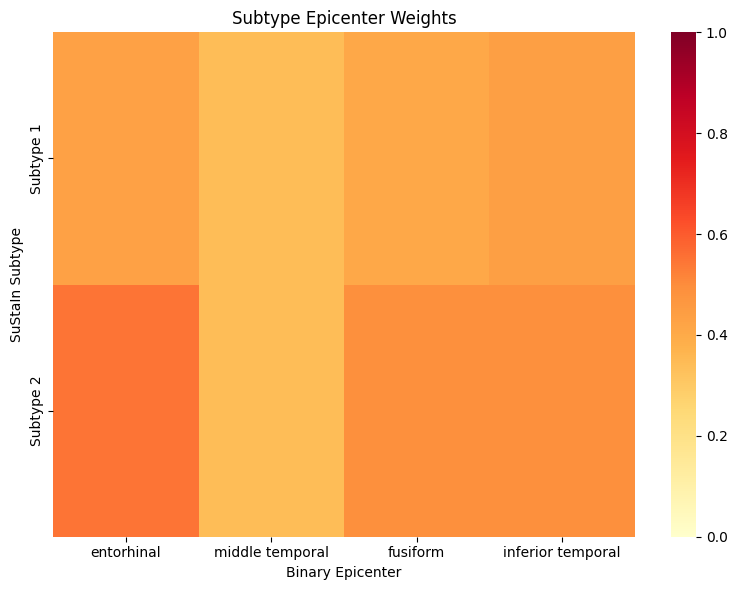

In [405]:
# Plot of heatmap of SuStaIn subtypes vs. binary epicenters (columns: subtype 1, subtype 2; rows: entorhinal, middle temporal, fusiform, inferior temporal)
subtype_epicenters_matrix = [[.43,.34,.41,.44],[.55,.34,.49,.49]]

# Create heatmap of subtype epicenters matrix
plt.figure(figsize=(8, 6))
sns.heatmap(subtype_epicenters_matrix, 
            annot=False, 
            fmt='.2f',
            cmap='YlOrRd',
            vmin=0,  # minimum value for the colormap
            vmax=1,  # maximum value for the colormap
            xticklabels=['entorhinal', 'middle temporal', 'fusiform', 'inferior temporal'],
            yticklabels=['Subtype 1', 'Subtype 2'])

plt.title('Subtype Epicenter Weights')
plt.xlabel('Binary Epicenter')
plt.ylabel('SuStaIn Subtype')
plt.tight_layout()
plt.show()






## Run eNDM on all subjects with recovered seeds

In [30]:
# Load recovered seeds
recovered_seeds_original = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Recovered seeds (from SVD)/Recovered seeds based on original etas.csv')
recovered_seeds_predicted = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Recovered seeds (from SVD)/Recovered seeds based on DNN predicted etas.csv')

stage_palette = sns.color_palette([
    "#E6F3FF",  # Lightest blue
    "#B3D9FF",  # Light blue
    "#80BFFF",  # Medium blue
    "#FFB366",  # Light orange
    "#FF944D",  # Medium orange
    "#FF7533",  # Dark orange
    "#FF471A",  # Light red
    "#CC0000",  # Deep red
])

In [31]:
# Select which recoverd seeds to use 
predicted = False # True if using DNN predicted etas, False if using original etas

# Avoid repeating any RIDS
original_rids = patient_data['RID'].unique()
if predicted:
    recovered_rids = recovered_seeds_predicted['RID'].unique()
else:
    recovered_rids = recovered_seeds_original['RID'].unique()
unique_rids = np.intersect1d(original_rids, recovered_rids)

# Create dictionary for entire eNDM time series for each subject
timeseries_recovered_dict = {}

# Set parameters for eNDM
parameters = [0.2117571, 0.170457, 1, 0.5, 0.0, 0.0, 50.]

# Create data frame for MSE and R between recovered eNDM and patient tau
column_names = ['RID', 'Diagnosis', 'ml_stage', 'MSE', 'R']
NDM_recovered_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    # Load patient data
    patient = patient_data[patient_data['RID'] == rid] 

    # Get initial vector from recovered seeds
    if predicted:
        recovered_seeds = recovered_seeds_predicted
    else:
        recovered_seeds = recovered_seeds_original
    init_vec_recovered = np.array(recovered_seeds.loc[recovered_seeds['RID'] == rid].iloc[0,2:])

    diagnosis = patient['Diagnosis'].iloc[0]
    ml_stage = patient['ml_stage'].iloc[0]

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,4:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Run eNDM    
    nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_recovered, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_)

    # Call the simulate_nexis method with the parameters
    Y = nexis_model.simulate_nexis(parameters)
    Y_edited = Y[:, stages]
    
    # Calculate MSE and R
    mse = mse_matrix(patient_tau, Y_edited)
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())

    # Create data frame for the subject (and time series)
    NDM_recovered = pandas.DataFrame([[rid] + [diagnosis] + [ml_stage] + [mse] + [corr_coeff]], columns=column_names)
    timeseries_recovered = pandas.DataFrame(Y)

    # Concatenate the original DataFrame with the new DataFrame
    NDM_recovered_all = pandas.concat([NDM_recovered_all, NDM_recovered], ignore_index=True)

    # Add timeseries DataFrame to timeseries_all_dict with RID as the key
    timeseries_recovered_dict[rid] = timeseries_recovered

NDM_recovered_all


/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_988/3482193828.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  NDM_recovered_all = pandas.concat([NDM_recovered_all, NDM_recovered], ignore_index=True)


,RID,Diagnosis,ml_stage,MSE,R
0,56,MCI,0.0,0.008824,0.846680
1,59,MCI,2.0,0.006127,0.838500
2,69,MCI,2.0,0.005802,0.812660
3,112,Dementia,7.0,0.010911,0.656217
4,127,MCI,2.0,0.005623,0.773737
...,...,...,...,...,...
241,6703,MCI,0.0,0.014341,0.714956
242,6704,MCI,1.0,0.002612,0.837704
243,6705,MCI,7.0,0.009871,0.635203
244,6721,Dementia,2.0,0.003924,0.833429



Mean correlation coefficient (R): 0.741


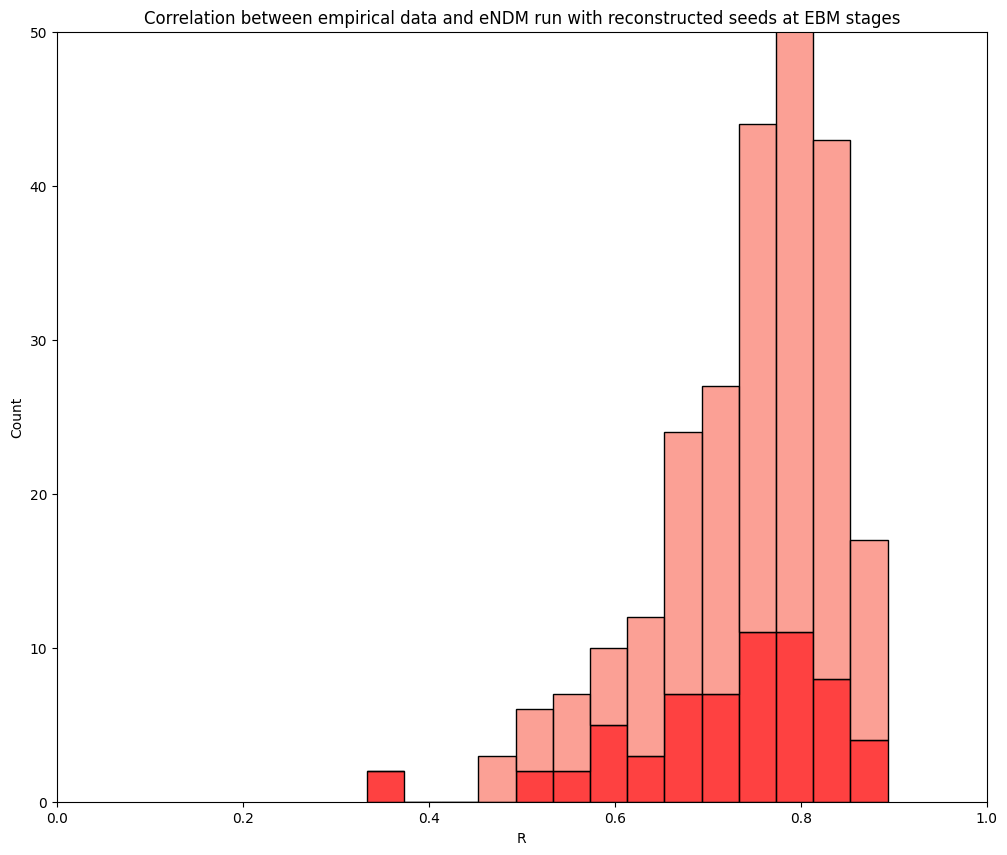

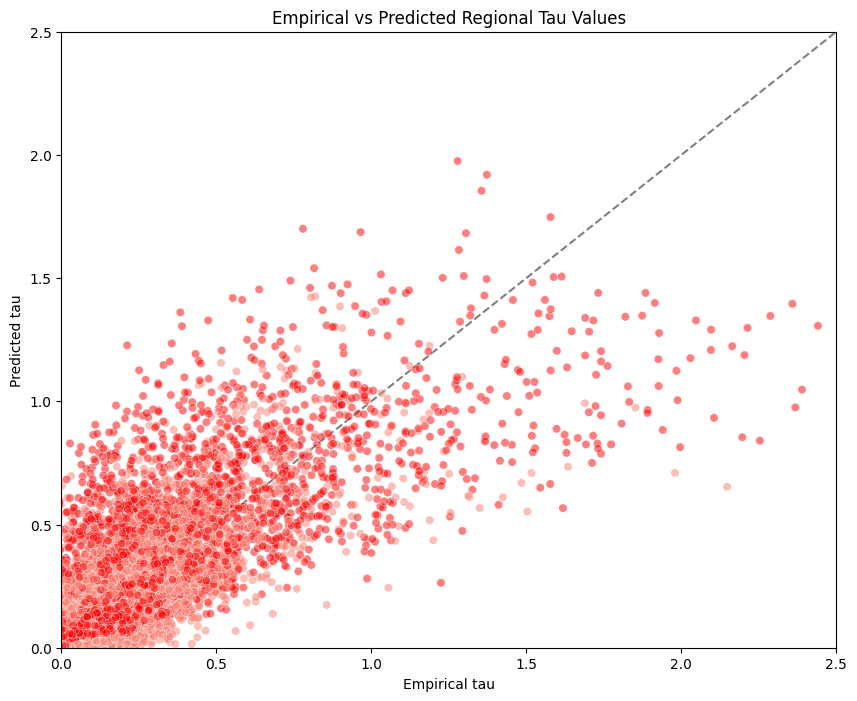

In [32]:
# Compare empirical data and eNDM run with reconstructed seeds (from original or DL-predicted etas) at ml_stage

# Plot R distirbution
color_palette = {
    'Dementia': '#FE0101',  # Deep red
    'MCI': '#FA8072',  # Salmon
    'CN': '#F5F5DC'}   # Beige (light beige)

# Calculate and print mean R value
mean_R = NDM_recovered_all['R'].mean()
print(f"\nMean correlation coefficient (R): {mean_R:.3f}")

# Plot R distribution with diagnosis-based stacking
plt.figure(figsize=(12, 10))
ax = sns.histplot(data=NDM_recovered_all, x='R', binwidth=0.04, hue='Diagnosis', 
                  multiple='stack', palette=color_palette, legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('Correlation between empirical data and eNDM run with reconstructed seeds at EBM stages')
plt.xlim(0, 1)
plt.ylim(0,50)
plt.show()



# Create scatter plot 
plt.figure(figsize=(10, 8))

all_empirical = []
all_predicted = []
diagnoses_points = []

# For each subject
for rid in timeseries_recovered_dict.keys():
    # Get the subject's ml_stage 
    ml_stage = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['ml_stage'].iloc[0]
    stage_idx = int(ml_stage)  # Convert to integer for indexing
    
    # Get empirical tau values (patient_tau) for this subject
    patient_empirical_recovered = patient_data[patient_data['RID'] == rid]
    empirical_tau = patient_empirical_recovered.iloc[0, 4:].values
    
    # Get predicted data at the corresponding stage
    predicted_tau = timeseries_recovered_dict[rid].iloc[:, stage_idx].values

    # Get diagnosis for this subject
    diagnosis = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['Diagnosis'].iloc[0]
    
    # Store values for plotting
    all_empirical.extend(empirical_tau)
    all_predicted.extend(predicted_tau)
    diagnoses_points.extend([diagnosis] * len(predicted_tau))

#Create DataFrame for plotting
scatter_df = pandas.DataFrame({
    'all_empirical': all_empirical,
    'all_predicted': all_predicted,
    'Diagnosis': diagnoses_points
})

# Create scatter plot
sns.scatterplot(data = scatter_df, x= 'all_empirical', y='all_predicted', hue='Diagnosis', 
                alpha=0.5, palette=color_palette, legend=False)

# Add y=x line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, 'k--', alpha=0.5, zorder=0)

plt.xlabel('Empirical tau')
plt.ylabel('Predicted tau')
plt.title('Empirical vs Predicted Regional Tau Values')
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.show()




Mean correlation coefficient (R): 0.741


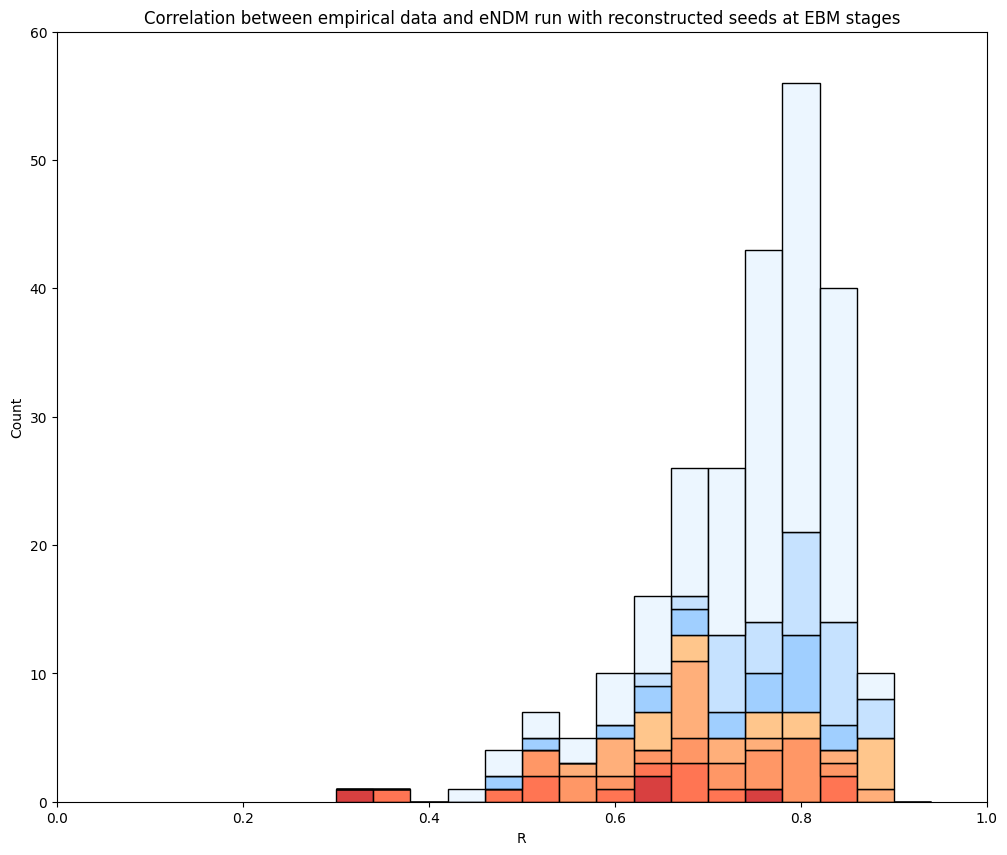

In [44]:
# Create stage bins including 0
NDM_recovered_all['stage_bin'] = pandas.cut(NDM_recovered_all['ml_stage'], 
                                          bins=[-0.1, 2, 4, 6, 8, 10, 12, 14, 16],  # Start at -0.1 to include 0
                                          labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16'])

# Calculate and print mean R value
mean_R = NDM_recovered_all['R'].mean()
print(f"\nMean correlation coefficient (R): {mean_R:.3f}")

# Plot R distribution with stage-based stacking
plt.figure(figsize=(12, 10))
ax = sns.histplot(data=NDM_recovered_all, x='R', bins=np.arange(0.3, 0.95, 0.04), 
                  hue='stage_bin', multiple='stack', palette=stage_palette, legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('Correlation between empirical data and eNDM run with reconstructed seeds at EBM stages')
plt.xlim(0, 1)
plt.ylim(0, 60)
plt.show()


Mean correlation coefficient (R): 0.783


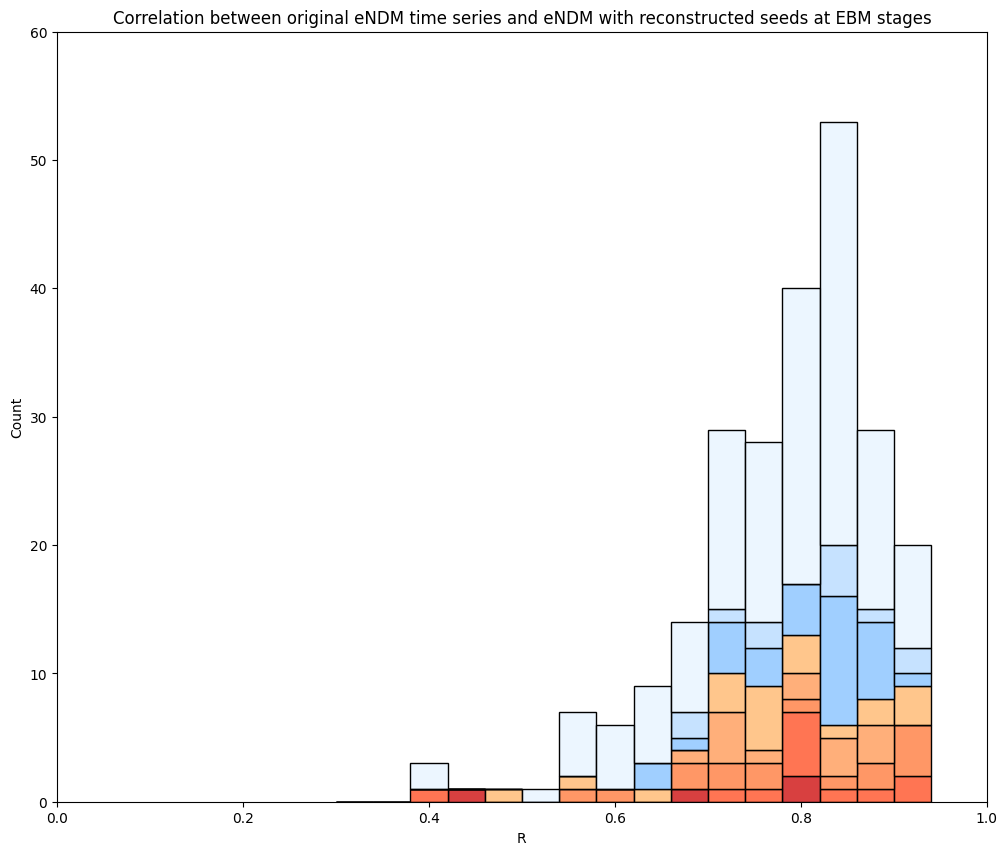

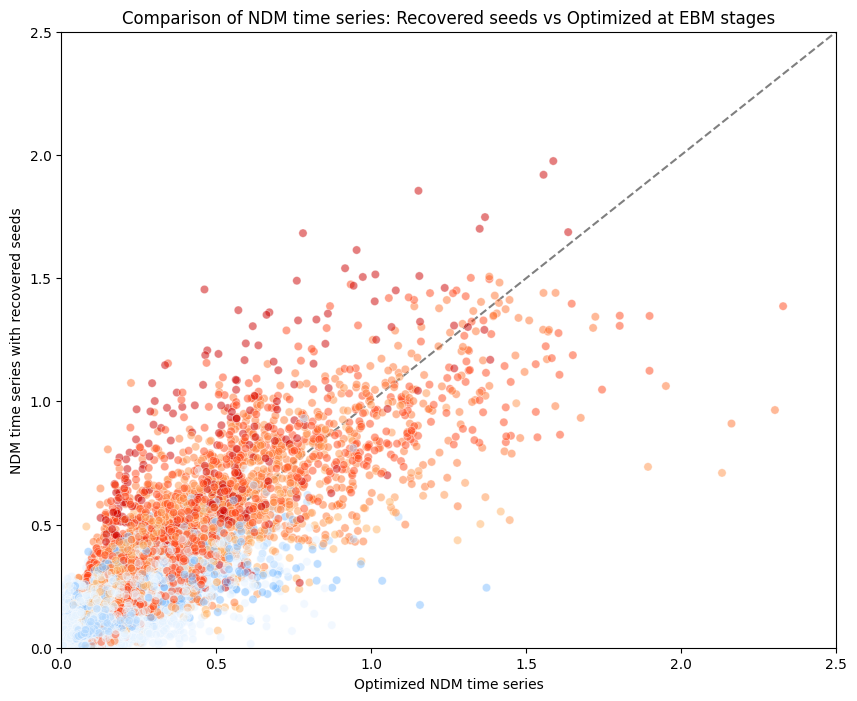

In [47]:
# Create stage bins including 0 (if not already created)
NDM_recovered_all['stage_bin'] = pandas.cut(NDM_recovered_all['ml_stage'], 
                                          bins=[-0.1, 2, 4, 6, 8, 10, 12, 14, 16],
                                          labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16'])

# Calculate R correlation between recovered and optimized time series for each subject
correlations_original_recovered = []
stages_original_recovered = []

for rid in timeseries_recovered_dict.keys():
    if rid in timeseries_all_dict:  # Make sure subject exists in both dictionaries
        # Get the subject's ml_stage and stage_bin
        ml_stage = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['ml_stage'].iloc[0]
        stage_bin = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['stage_bin'].iloc[0]
        stage_idx = int(ml_stage)  # Convert to integer for indexing
        
        # Get time series data for this subject at their specific stage
        recovered_ts = timeseries_recovered_dict[rid].values[:, stage_idx]
        optimized_ts = timeseries_all_dict[rid].values[:, stage_idx]
        
        # Calculate correlation
        corr_coeff, _ = pearsonr(recovered_ts, optimized_ts)
        correlations_original_recovered.append(corr_coeff)
        stages_original_recovered.append(stage_bin)

# Create DataFrame with results
comparison_df_original_recovered = pandas.DataFrame({
    'R': correlations_original_recovered,
    'Stage': stages_original_recovered
})

# Calculate and print mean R value
mean_R = comparison_df_original_recovered['R'].mean()
print(f"\nMean correlation coefficient (R): {mean_R:.3f}")

# Plot R distribution 
plt.figure(figsize=(12,10))
ax = sns.histplot(data=comparison_df_original_recovered, x='R', bins=np.arange(0.3, 0.95, 0.04), 
                  hue='Stage', multiple='stack', palette=stage_palette, legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('Correlation between original eNDM time series and eNDM with reconstructed seeds at EBM stages')
plt.xlim(0, 1)
plt.ylim(0,60)
plt.show()

# Create scatter plot
plt.figure(figsize=(10, 8))

# Initialize lists to store all points
recovered_points = []
optimized_points = []
stages_points = []

# Collect points for each subject
for rid in timeseries_recovered_dict.keys():
    if rid in timeseries_all_dict:  # Make sure subject exists in both dictionaries
        # Get the subject's stage_bin
        stage_bin = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['stage_bin'].iloc[0]
        ml_stage = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['ml_stage'].iloc[0]
        stage_idx = int(ml_stage)
        
        # Get time series data for this subject at their specific stage
        recovered_ts = timeseries_recovered_dict[rid].values[:, stage_idx]
        optimized_ts = timeseries_all_dict[rid].values[:, stage_idx]
        
        # Add all points for this subject
        recovered_points.extend(recovered_ts)
        optimized_points.extend(optimized_ts)
        stages_points.extend([stage_bin] * len(recovered_ts))

# Create DataFrame for plotting
scatter_df_original_recovered = pandas.DataFrame({
    'Recovered': recovered_points,
    'Optimized': optimized_points,
    'Stage': stages_points
})

# Create scatter plot
sns.scatterplot(data=scatter_df_original_recovered, x='Optimized', y='Recovered', 
                hue='Stage', palette=stage_palette, alpha=0.5, legend=False)

# Add y=x line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, 'k--', alpha=0.5, zorder=0)

plt.xlabel('Optimized NDM time series')
plt.ylabel('NDM time series with recovered seeds')
plt.title('Comparison of NDM time series: Recovered seeds vs Optimized at EBM stages')
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.show()


Mean correlation coefficient (R): 0.783


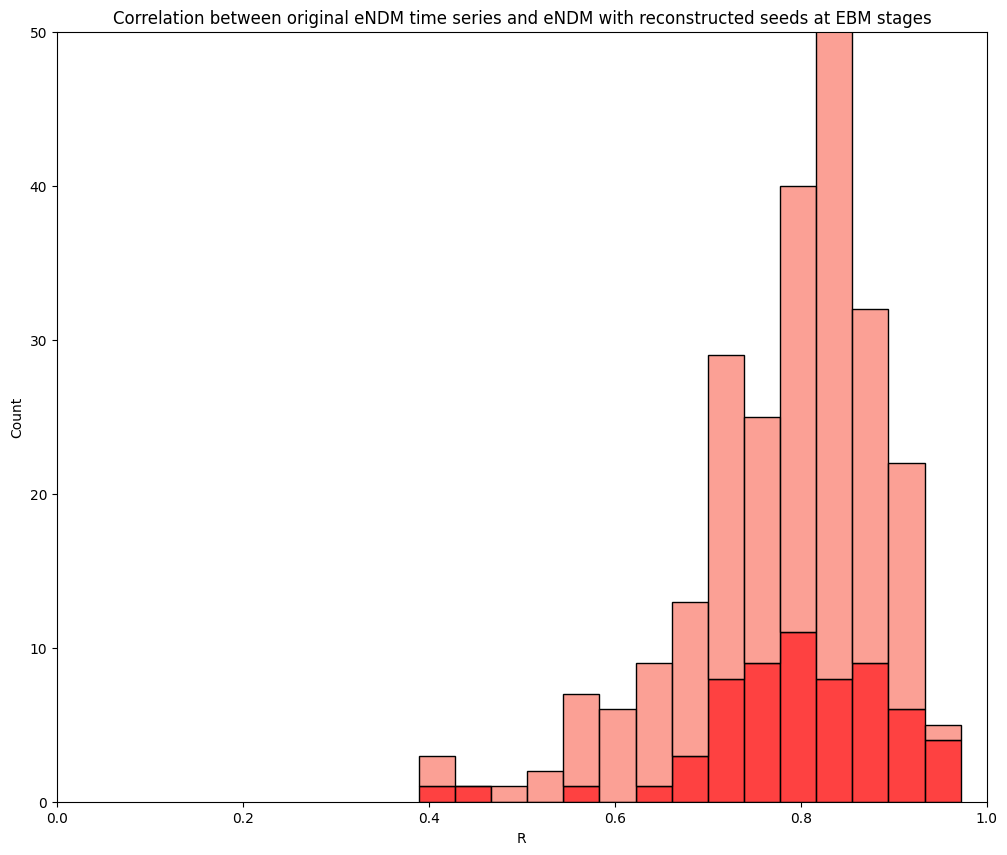


Mean R values by diagnosis:
Diagnosis
Dementia    0.793246
MCI         0.779973
Name: R, dtype: float64


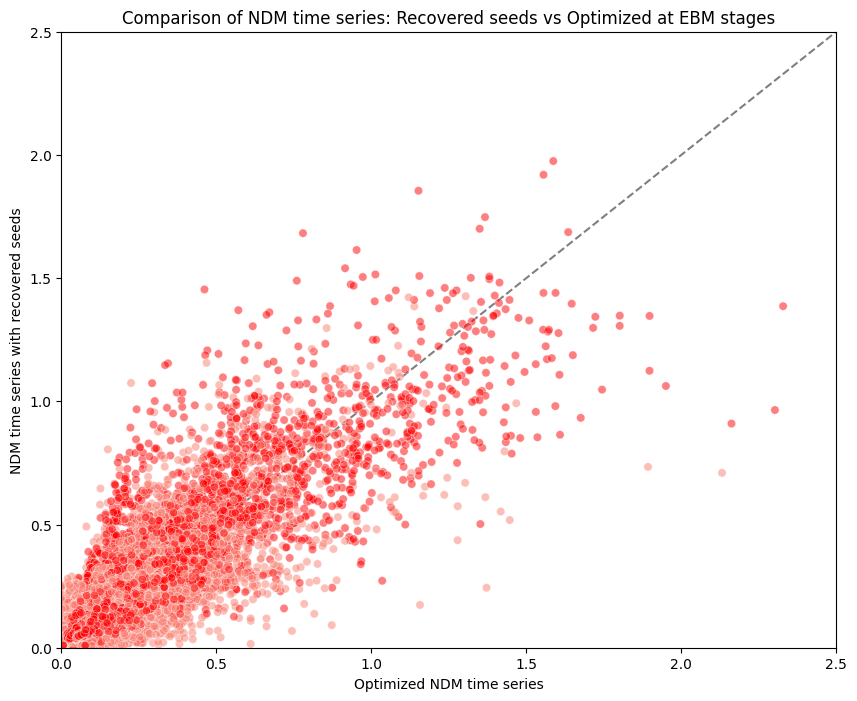

In [33]:
# Correlation between eNDM with original seeds (the original models) and eNDM with reconstructed seeds (original or DL-predicted etas) at ml_stage

# Load the dictionary from the previous run
import pickle

# Load timeseries_all_dict from the saved file
with open('seed vs. param op/timeseries_all_dict.pkl', 'rb') as f:
    timeseries_all_dict = pickle.load(f)

# Calculate R correlation between recovered and optimized time series for each subject at their ml_stage
correlations_original_recovered = []
diagnoses_original_recovered = []

for rid in timeseries_recovered_dict.keys():
    if rid in timeseries_all_dict:  # Make sure subject exists in both dictionaries
        # Get the subject's ml_stage
        ml_stage = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['ml_stage'].iloc[0]
        stage_idx = int(ml_stage)  # Convert to integer for indexing
        
        # Get time series data for this subject at their specific stage
        recovered_ts = timeseries_recovered_dict[rid].values[:, stage_idx]
        optimized_ts = timeseries_all_dict[rid].values[:, stage_idx]
        
        # Calculate correlation
        corr_coeff, _ = pearsonr(recovered_ts, optimized_ts)
        correlations_original_recovered.append(corr_coeff)
        
        # Get diagnosis for this subject
        diagnosis = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['Diagnosis'].iloc[0]
        diagnoses_original_recovered.append(diagnosis)

# Create DataFrame with results
comparison_df_original_recovered = pandas.DataFrame({
    'R': correlations_original_recovered,
    'Diagnosis': diagnoses_original_recovered
})

# Calculate and print mean R value
mean_R = comparison_df_original_recovered['R'].mean()
print(f"\nMean correlation coefficient (R): {mean_R:.3f}")

# Plot R distribution 
plt.figure(figsize=(12,10))
ax = sns.histplot(data=comparison_df_original_recovered, x='R', binwidth=0.04, hue='Diagnosis', 
                  multiple='stack', palette=color_palette, legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('Correlation between original eNDM time series and eNDM with reconstructed seeds at EBM stages')
plt.xlim(0, 1)
plt.ylim(0,50)
plt.show()

# Print mean R by diagnosis
print("\nMean R values by diagnosis:")
print(comparison_df_original_recovered.groupby('Diagnosis')['R'].mean())




# Create scatter plot
plt.figure(figsize=(10, 8))

# Initialize lists to store all points
recovered_points = []
optimized_points = []
diagnoses_points = []

# Collect points for each subject
for rid in timeseries_recovered_dict.keys():
    if rid in timeseries_all_dict:  # Make sure subject exists in both dictionaries
        # Get the subject's ml_stage
        ml_stage = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['ml_stage'].iloc[0]
        stage_idx = int(ml_stage)  # Convert to integer for indexing
        
        # Get time series data for this subject at their specific stage
        recovered_ts = timeseries_recovered_dict[rid].values[:, stage_idx]
        optimized_ts = timeseries_all_dict[rid].values[:, stage_idx]
        
        # Get diagnosis for this subject
        diagnosis = NDM_recovered_all[NDM_recovered_all['RID'] == rid]['Diagnosis'].iloc[0]
        
        # Add all points for this subject
        recovered_points.extend(recovered_ts)
        optimized_points.extend(optimized_ts)
        diagnoses_points.extend([diagnosis] * len(recovered_ts))

# Create DataFrame for plotting
scatter_df_original_recovered = pandas.DataFrame({
    'Recovered': recovered_points,
    'Optimized': optimized_points,
    'Diagnosis': diagnoses_points
})

# Create scatter plot
sns.scatterplot(data=scatter_df_original_recovered, x='Optimized', y='Recovered', hue='Diagnosis', 
                alpha=0.5, palette=color_palette, legend=False)

# Add y=x line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, 'k--', alpha=0.5, zorder=0)

plt.xlabel('Optimized NDM time series')
plt.ylabel('NDM time series with recovered seeds')
plt.title('Comparison of NDM time series: Recovered seeds vs Optimized at EBM stages')
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.show()


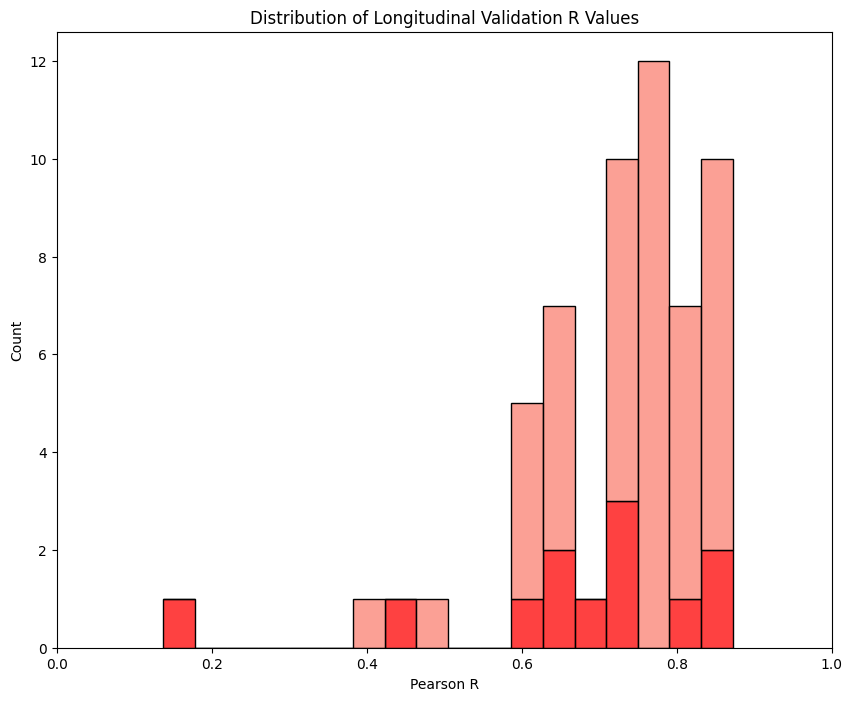

Average longitudinal validation R: 0.724


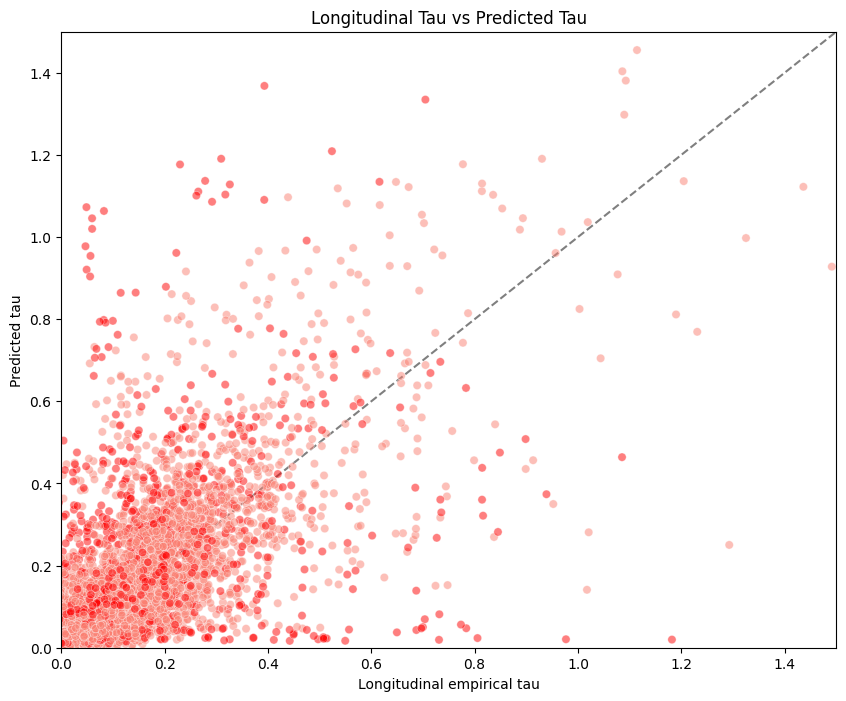

In [147]:
# Compare eNDM with reconstructed seeds (original or DL-predicted etas) vs. empirical longitudinal data at ml_stage

longitudinal_stage_tau = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM stage + tau/longitudinal_stage_tau- organized.csv')

# Filter out RIDs with NaN in ml_stage column 
longitudinal_stage_tau = longitudinal_stage_tau[
    (longitudinal_stage_tau['ml_stage'].notna())
]
# Remove RIDs with CN diagnosis
longitudinal_stage_tau = longitudinal_stage_tau[
    longitudinal_stage_tau['DX'] != 'CN'
]
# Keep only longitudinal follow up data
longitudinal_stage_tau = longitudinal_stage_tau.groupby('RID').nth(1).reset_index()
RIDS_with_longitudinal = longitudinal_stage_tau['RID'].unique()

# Calculate R between empirical longitudinal data and eNDM with reconstructed seeds at ml_stage
longitudinal_validation_results = []

# For each RID with longitudinal data
for rid in RIDS_with_longitudinal:
    # Convert rid to regular integer
    rid = int(rid)
    
    # Check if we have both recovered predictions and NDM data for this RID
    if rid in timeseries_recovered_dict and any(NDM_recovered_all['RID'] == rid):
        try:
            # Get the subject's data and stage
            patient_data_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]
            ml_stage = patient_data_longitudinal['ml_stage'].iloc[0]
            stage_idx = int(ml_stage)
            
            # Get empirical tau values and convert to float
            empirical_tau = patient_data_longitudinal.iloc[0, 7:].astype(float).values
            
            # Get predicted data at the corresponding stage
            predicted_tau = timeseries_recovered_dict[rid].iloc[:, stage_idx].values
            
            # Check if arrays are valid and same length
            if (len(empirical_tau) == len(predicted_tau) and 
                not any(pandas.isna(empirical_tau)) and 
                not any(pandas.isna(predicted_tau))):
                
                # Calculate correlation
                corr_coeff, p_value = pearsonr(empirical_tau, predicted_tau)
                
                # Get diagnosis
                diagnosis = patient_data_longitudinal['DX'].iloc[0]
                
                # Store results
                longitudinal_validation_results.append({
                    'RID': rid,
                    'R_longitudinal': corr_coeff,
                    'Diagnosis': diagnosis
                })
        except Exception as e:
            print(f"Error processing RID {rid}: {str(e)}")
            continue

# Convert results to DataFrame
longitudinal_validation_df = pandas.DataFrame(longitudinal_validation_results)


# Create histogram of longitudinal validation R values
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=longitudinal_validation_df, x='R_longitudinal', binwidth=0.04, hue='Diagnosis', 
                  multiple='stack', palette=color_palette, legend=False)
plt.xlabel('Pearson R')
plt.ylabel('Count') 
plt.title('Distribution of Longitudinal Validation R Values')
plt.xlim(0, 1)
plt.show()


# Calculate and print average R_longitudinal
mean_r_longitudinal = longitudinal_validation_df['R_longitudinal'].mean()
print(f"Average longitudinal validation R: {mean_r_longitudinal:.3f}")



# Create scatter plot 
plt.figure(figsize=(10, 8))

all_longitudinal = []
all_predicted = []
diagnoses_points = []

# For each subject
for rid in RIDS_with_longitudinal:
    # Convert rid to regular integer
    rid = int(rid)
    
    if rid in timeseries_recovered_dict:  # Check if we have predictions for this RID
        try:
            # Get the subject's ml_stage 
            ml_stage = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]['ml_stage'].iloc[0]
            stage_idx = int(ml_stage)  # Convert to integer for indexing
            
            # Get empirical tau values for this subject
            patient_longitudinal = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]
            empirical_longitudinal = patient_longitudinal.iloc[0, 7:].values
            
            # Get predicted data at the corresponding stage
            predicted_tau = timeseries_recovered_dict[rid].iloc[:, stage_idx].values

            # Get diagnosis for this subject
            diagnosis = longitudinal_stage_tau[longitudinal_stage_tau['RID'] == rid]['DX'].iloc[0]
            
            # Store values for plotting
            all_longitudinal.extend(empirical_longitudinal)
            all_predicted.extend(predicted_tau)
            diagnoses_points.extend([diagnosis] * len(predicted_tau))
        except Exception as e:
            print(f"Error processing RID {rid}: {str(e)}")
            continue

# Create DataFrame for plotting
scatter_df_longitudinal = pandas.DataFrame({
    'all_longitudinal': all_longitudinal,
    'all_predicted': all_predicted,
    'Diagnosis': diagnoses_points
})


# Create scatter plot
sns.scatterplot(data = scatter_df_longitudinal, x= 'all_longitudinal', y='all_predicted', hue='Diagnosis', 
                alpha=0.5, palette=color_palette, legend=False)

# Add y=x line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, 'k--', alpha=0.5, zorder=0)

plt.xlabel('Longitudinal empirical tau')
plt.ylabel('Predicted tau')
plt.title('Longitudinal Tau vs Predicted Tau')
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.show()



In [118]:
# Sort NDM_recovered_all by R values in descending order(to determine which subjects are best for showcasing)
top_performers = NDM_recovered_all.sort_values('R', ascending=False)

# Display top 10 RIDs with highest R values
print("Top 10 RIDs with highest R values:")
print(top_performers[['RID', 'Diagnosis', 'ml_stage', 'R', 'MSE']].head(10))

# Optional: Calculate mean R by diagnosis
print("\nMean R values by diagnosis:")
print(NDM_recovered_all.groupby('Diagnosis')['R'].mean())

Top 10 RIDs with highest R values:
      RID Diagnosis  ml_stage         R       MSE
202  6483       MCI       9.0  0.904796  0.009079
177  6336       MCI       4.0  0.886664  0.009313
166  6258       MCI       3.0  0.885235  0.003858
60   4094  Dementia       1.0  0.880571  0.002146
186  6377  Dementia       7.0  0.874753  0.013943
112  4782       MCI       7.0  0.870536  0.020803
187  6389  Dementia       4.0  0.866826  0.003689
122  4869       MCI       0.0  0.864997  0.001948
101  4631  Dementia       0.0  0.863915  0.002894
154  6142  Dementia       8.0  0.862420  0.010521

Mean R values by diagnosis:
Diagnosis
Dementia    0.701914
MCI         0.732485
Name: R, dtype: float64


In [106]:
# Define the region names (excluding the regions_to_exclude)
regions_included = [region for region in regions if region not in regions_to_exclude]

# Convert each timeseries in the dictionary
formatted_timeseries_dict = {}
for rid, timeseries in timeseries_recovered_dict.items():
    # Transpose the DataFrame to make it 19 x 78
    formatted_df = timeseries.T
    
    # Set the column names to region names
    formatted_df.columns = regions_included
    
    # Store in new dictionary
    formatted_timeseries_dict[rid] = formatted_df

# Verify the format of one entry
print(f"Shape of first entry: {next(iter(formatted_timeseries_dict.values())).shape}")
print(f"Column names match regions: {all(next(iter(formatted_timeseries_dict.values())).columns == regions_included)}")

Shape of first entry: (19, 78)
Column names match regions: True


In [108]:
# Save times series from recovered seeds to visualize with Pysurfer 
formatted_timeseries_dict[6483].to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/visualization/Pysurfer data/Recovered time series 6483 (original etas).csv')